In [1]:
import gymnasium as gym
import math
import statistics
import random
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from collections import Counter
import os 
import pickle
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from polygon import RESTClient
from datetime import datetime, time, timedelta
from pytz import timezone

TZONE = timezone("US/Eastern")

client = RESTClient("_97S9e6jWlbjHj0Ok5iiFp_gfrhuYYTV")

OPEN = datetime.fromisoformat("2023-02-03 09:30:00-05:00")
CLOSE = datetime.fromisoformat('2023-02-03 16:00:00-05:00')

In [90]:
OPEN

datetime.datetime(2023, 2, 3, 9, 30, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400)))

In [2]:
top_8_tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'TSM']
top_4_tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

used_tech = top_8_tech

In [92]:
# run this to load the data wo re-downloading
end = datetime.now()
start = end - timedelta(days=365*5)
SAVE_DIR = "../data/stocksv3/"

ticker_data = {}
ticker_market_caps = {}

for ticker in used_tech:
    curdir = os.path.join(SAVE_DIR, ticker)
    if not os.path.isdir(curdir):
        os.mkdir(curdir)
    
    datas = list(client.list_aggs(ticker, 1, "minute", str(start.date()), str(end.date())))
    df = pd.DataFrame(datas)
    df = df.set_index(df['timestamp'].map(lambda x: datetime.fromtimestamp(x/1000, tz=TZONE)))
    ticker_data[ticker] = df 
    df.to_csv(os.path.join(curdir, f"{ticker}.csv"))
    
    market_cap = client.get_ticker_details("AAPL").market_cap
    with open(os.path.join(curdir, f"ticker_market_cap.pkl"), "wb") as file:
        pickle.dump({"market_cap": market_cap}, file)
    
    

KeyboardInterrupt: 

In [3]:
# run this to load the data
ticker_data = {}
ticker_market_caps = {}

SAVE_DIR = "../data/stocksv3/"

for ticker in used_tech:
    curdir = os.path.join(SAVE_DIR, ticker)
    
    df = pd.read_csv(os.path.join(curdir, f"{ticker}.csv"))
    df = df.set_index(df['timestamp.1'].map(lambda x: datetime.fromtimestamp(x/1000, tz=TZONE)))
    ticker_data[ticker] = df
    with open(os.path.join(curdir, f"ticker_market_cap.pkl"), "rb") as file:
        market_cap = pickle.load(file)
        
    ticker_market_caps[ticker] = market_cap["market_cap"]



In [ ]:
ticker_data["AAPL"]

,timestamp,open,high,low,close,volume,vwap,timestamp.1,transactions,otc
timestamp.1,,,,,,,,,,
2018-07-10 04:00:00-04:00,2018-07-10 04:00:00-04:00,47.6425,47.6425,47.6425,47.6425,1068.0,47.6425,1531209600000,1.0,NaN
2018-07-10 04:01:00-04:00,2018-07-10 04:01:00-04:00,47.5650,47.5650,47.5650,47.5650,1200.0,47.5656,1531209660000,2.0,NaN
2018-07-10 05:22:00-04:00,2018-07-10 05:22:00-04:00,47.5650,47.5650,47.5625,47.5650,5488.0,47.5643,1531214520000,6.0,NaN
2018-07-10 05:28:00-04:00,2018-07-10 05:28:00-04:00,47.5925,47.6025,47.5925,47.6025,4400.0,47.5994,1531214880000,4.0,NaN
2018-07-10 05:32:00-04:00,2018-07-10 05:32:00-04:00,47.6250,47.6425,47.6250,47.6425,1820.0,47.6427,1531215120000,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-07-07 19:49:00-04:00,2023-07-07 19:49:00-04:00,190.9500,190.9500,190.9500,190.9500,292.0,190.9283,1688773740000,16.0,NaN
2023-07-07 19:55:00-04:00,2023-07-07 19:55:00-04:00,190.8900,190.9006,190.8900,190.9006,1005.0,190.8969,1688774100000,15.0,NaN
2023-07-07 19:56:00-04:00,2023-07-07 19:56:00-04:00,190.9000,190.9100,190.9000,190.9000,1397.0,190.9018,1688774160000,29.0,NaN


# Write an environemnt that will simulate the stock market based on historical data. 

This assumes:

1) actions have no market impact

2) actions can be done instantly

In [ ]:
ticker_data["AAPL"].index[0].time()

datetime.time(4, 0)

In [ ]:
OPEN.time()

datetime.time(9, 30)

In [79]:
def check_same_day(dt1, dt2):
    return dt1.date() == dt2.date()

def intersect_multiple_arrays(list_arrays):
    assert len(list_arrays) > 0, "Must have at least 1 array to take the intersection"
    if len(list_arrays) == 1:
        return list_arrays[0]
    cum_arr = np.intersect1d(list_arrays[0], list_arrays[1])
    for jj in range(2, len(list_arrays)):
        cum_arr = np.intersect1d(cum_arr, list_arrays[jj])
        
    return cum_arr

def is_open(dt):
    return dt.hour == 9 and dt.minute == 30

def is_close(dt):
    return dt.hour == 16 and dt.minute == 0

class StockGameSimulatorv3:
    def __init__(self, datas, market_caps, used_tech, eval_hold = 0.33, included_lag = 0, enforce_same_day = False,
                 labels_to_include=['open', 'high', 'low', 'close', 'volume', 'vwap'], 
                 labels_to_correct=['open', 'high', 'low', 'close',], div_factor = 1000000000000,
                 missing_cutoff = 30):
        
        self.datas = datas
        self.market_caps = market_caps
        self.eval_hold = eval_hold
        self.included_lag = included_lag
        self.enforce_same_day = enforce_same_day
        self.used_tech = used_tech
        self.labels_to_include = labels_to_include
        self.labels_to_correct = labels_to_correct
        self.div_factor = div_factor
        self.missing_cutoff = 30
        
        self.preprocess_datas()
    
    def preprocess_datas(self):
        # Make sure all the dataframes have the same datetimes
        # for tech1 in self.used_tech:
        #     for tech2 in self.used_tech:
        #         assert (self.datas[tech1].index == self.datas[tech2].index).all(), "All indexes must be the same in datas"
        
        daystarts = []
        dayends = []

        ds = None
        for ts in self.datas[self.used_tech[0]].index:
            
            if is_open(ts):
                ds = ts 
            if is_close(ts) and ds is not None and ts.date() == ds.date():
                # print(ds)
                # print(ts)
                # print("^"*20)
                daystarts.append(ds)
                dayends.append(ts)
        # print(daystarts[-1], dayends[-1])
        # print(len(daystarts), len(dayends))
        assert len(daystarts) == len(dayends), "Opens must equal closes in the dataset, this may be caused by downloading midday"    
        
        self.num_shares = {}
        for ticker in self.used_tech:
            self.num_shares[ticker] = int(self.market_caps[ticker]/self.datas[ticker].loc[dayends[-1]]['close'])
        
        # Normalize the datatables 
        for ticker in self.used_tech:
            df = self.datas[ticker]
            for col in self.labels_to_include:
                if col in self.labels_to_correct:
                    # If correction is required, we want it to reflect total value of the company
                    df[col] = df[col].apply(lambda x: x * (self.num_shares[ticker] / self.div_factor))
                else:
                    # Otherwise, normalize by the total number of shares, useful for volume
                    df[col] = df[col].apply(lambda x: x / self.num_shares[ticker])
                    
        print("BEGIN LOOP ONE")
        # Loop through each day
        T_day = []; X_day = []; R_day = []
        for day_start, day_end in zip(daystarts, dayends):
            # print(day_start, day_end)
            day_index = self.datas[self.used_tech[0]].loc[day_start:day_end].index # intersect_multiple_arrays([self.datas[xx].loc[day_start:day_end].index for xx in self.used_tech])
            # print(day_start, day_end, day_index)
            
            
            X = []; R = []
            missing_data = {kk: 0 for kk in self.used_tech}
            for idx in day_index:            
                x = np.zeros((len(self.used_tech), len(self.labels_to_include)))
                r = []
                for ii, ticker in enumerate(self.used_tech):
                    add_zeros = True
                    try:
                        cur_info = self.datas[ticker].loc[idx]
                        add_zeros = False
                    except:
                        missing_data[ticker] += 1
                    
                    r.append(cur_info['close']/cur_info['open'] - 1)
                    for jj, label in enumerate(self.labels_to_include):
                        x[ii, jj] = 0 if add_zeros else cur_info[label]
                        
                X.append(x); R.append(r)
            
            is_good = True
            # Make sure none of the stocks arent missing too much data
            for kk in self.used_tech:
                if missing_data[kk] > self.missing_cutoff:
                    print(f"\t{kk} missing too much data on {day_start}, removing this day")
                    is_good = False
            if is_good:
                T_day.append(list(day_index)); X_day.append(X); R_day.append(R)
            
        assert len(T_day) == len(X_day) == len(R_day), "Internal Error: Loc 1"
        print(f"\t{len(T_day)} days processed!")
        
        print("BEGIN LOOP TWO")     
        # Generate Lags
        T_lagged_d = []; X_lagged_d = []; R_lagged_d = []
        for day_idx in range(len(T_day)):
            T_lagged = []; X_lagged = []; R_lagged = []
            for interday_idx in range(len(T_day[day_idx]) - 1): # Subtract 1 since rewards are forward looking
                
                if interday_idx < self.included_lag:
                    # print("here")
                    continue
                # print("here2")
                T_lagged.append(T_day[day_idx][interday_idx])
                X_lagged.append(np.array(X_day[day_idx][interday_idx-self.included_lag:interday_idx]))
                R_lagged.append(R_day[day_idx][interday_idx+1])
            T_lagged_d.append(T_lagged); X_lagged_d.append(X_lagged); R_lagged_d.append(R_lagged)
        
        assert len(T_lagged_d) == len(X_lagged_d) == len(R_lagged_d), "Internal Error: Loc 2"
            
        self.T = T_lagged_d
        self.X = X_lagged_d
        self.R = R_lagged_d
        
        # Set current index to zero
        self.day_index = 0
        self.intraday_index = 0

        all_ndx = np.arange(len(self.X))
        self.training_set = np.random.choice(all_ndx, int(len(self.X)*self.eval_hold), replace=False)
        self.evaluation_set = np.setdiff1d(all_ndx, self.training_set)
    
    def _get_train_index(self):
        return self.training_set[self.day_index]
    
    def _get_eval_index(self):
        return self.evaluation_set[self.day_index]
    
    def _get_state(self, train=True):
        day_idx = self._get_train_index() if train else self._get_eval_index()
        # print(day_idx, self.X[day_idx])
        return self.X[day_idx][self.intraday_index].flatten()
    
    def _get_reward(self, action, train=True):
        norm_action = action/np.sum(np.abs(action))
        day_idx = self._get_train_index() if train else self._get_eval_index()
        
        ind_stock_rewards = self.R[day_idx][self.current_index]
        
        algo_reward = np.dot(norm_action, ind_stock_rewards)
        
        # default_action = np.ones_like(norm_action)/len(norm_action)
        # default_reward = np.dot(default_action, ind_stock_rewards)
        
        return algo_reward # - default_reward
    
    def reset(self, train=True):
        self.day_index = 0
        self.current_index = 0
        return self._get_state(train=train)
        
    def step(self, action, train=True):
        
        # print(f"Date = {self.T[self._get_train_index()][self.intraday_index]}, idx = {self.intraday_index}, dix = {self.day_index}")
        if self.intraday_index > len(self.T[self.day_index]) - self.included_lag:
            # print("/t here")
            self.day_index += 1
            self.intraday_index = 0
        if train:
            done = 0 if self.day_index<len(self.training_set)-1 else 1
        else:
            done = 0 if self.day_index<len(self.evaluation_set)-1 else 1
            
        self.intraday_index += 1
        
        if train:
            return self._get_state(train=train), self._get_reward(action, train=train), done
        
        return self._get_state(train=train), self._get_reward(action, train=train), self._get_reward(np.array([.25]*len(action)), train=train), done

In [19]:
np.ones_like(np.array([1,2,3,4]))

array([1, 1, 1, 1])

In [26]:
list(ticker_data.keys())

In [80]:
stocks_to_use = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA']
env = StockGameSimulatorv3(ticker_data, ticker_market_caps, stocks_to_use, included_lag=3)

BEGIN LOOP ONE
	GOOG missing too much data on 2018-07-10 09:30:00-04:00, removing this day
	GOOG missing too much data on 2018-08-09 09:30:00-04:00, removing this day
	GOOG missing too much data on 2018-09-14 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-03-29 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-04-02 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-04-04 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-04-08 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-04-09 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-04-10 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-04-11 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-04-24 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-06-14 09:30:00-04:00, removing this day
	GOOG missing too much data on 2019-11-13 09:30:00-05:00, removing this d

In [75]:
len(env.T[0])

387

In [ ]:
print([str(xx) for xx in ticker_data["GOOG"].index[0:100]])

['2018-07-10 05:31:00-04:00', '2018-07-10 07:47:00-04:00', '2018-07-10 08:03:00-04:00', '2018-07-10 08:25:00-04:00', '2018-07-10 08:26:00-04:00', '2018-07-10 08:39:00-04:00', '2018-07-10 09:09:00-04:00', '2018-07-10 09:28:00-04:00', '2018-07-10 09:30:00-04:00', '2018-07-10 09:31:00-04:00', '2018-07-10 09:32:00-04:00', '2018-07-10 09:33:00-04:00', '2018-07-10 09:34:00-04:00', '2018-07-10 09:35:00-04:00', '2018-07-10 09:36:00-04:00', '2018-07-10 09:37:00-04:00', '2018-07-10 09:38:00-04:00', '2018-07-10 09:39:00-04:00', '2018-07-10 09:40:00-04:00', '2018-07-10 09:41:00-04:00', '2018-07-10 09:42:00-04:00', '2018-07-10 09:43:00-04:00', '2018-07-10 09:44:00-04:00', '2018-07-10 09:45:00-04:00', '2018-07-10 09:46:00-04:00', '2018-07-10 09:47:00-04:00', '2018-07-10 09:48:00-04:00', '2018-07-10 09:49:00-04:00', '2018-07-10 09:50:00-04:00', '2018-07-10 09:51:00-04:00', '2018-07-10 09:52:00-04:00', '2018-07-10 09:53:00-04:00', '2018-07-10 09:54:00-04:00', '2018-07-10 09:55:00-04:00', '2018-07-10 0

In [ ]:
print(list([str(xx) for xx in ticker_data["MSFT"].index[0:1000]]))


['2018-07-10 05:30:00-04:00', '2018-07-10 05:55:00-04:00', '2018-07-10 05:57:00-04:00', '2018-07-10 06:05:00-04:00', '2018-07-10 06:23:00-04:00', '2018-07-10 06:24:00-04:00', '2018-07-10 06:25:00-04:00', '2018-07-10 06:54:00-04:00', '2018-07-10 06:59:00-04:00', '2018-07-10 07:00:00-04:00', '2018-07-10 07:07:00-04:00', '2018-07-10 07:14:00-04:00', '2018-07-10 07:15:00-04:00', '2018-07-10 07:17:00-04:00', '2018-07-10 07:26:00-04:00', '2018-07-10 07:29:00-04:00', '2018-07-10 07:32:00-04:00', '2018-07-10 07:41:00-04:00', '2018-07-10 07:46:00-04:00', '2018-07-10 07:49:00-04:00', '2018-07-10 07:51:00-04:00', '2018-07-10 08:00:00-04:00', '2018-07-10 08:03:00-04:00', '2018-07-10 08:12:00-04:00', '2018-07-10 08:13:00-04:00', '2018-07-10 08:14:00-04:00', '2018-07-10 08:19:00-04:00', '2018-07-10 08:20:00-04:00', '2018-07-10 08:25:00-04:00', '2018-07-10 08:26:00-04:00', '2018-07-10 08:27:00-04:00', '2018-07-10 08:29:00-04:00', '2018-07-10 08:31:00-04:00', '2018-07-10 08:33:00-04:00', '2018-07-10 0

# Define the RL framework 

In [ ]:
print(list([str(xx) for xx in ticker_data["AAPL"].index[0:1000]]))

['2018-07-10 04:00:00-04:00', '2018-07-10 04:01:00-04:00', '2018-07-10 05:22:00-04:00', '2018-07-10 05:28:00-04:00', '2018-07-10 05:32:00-04:00', '2018-07-10 05:56:00-04:00', '2018-07-10 05:58:00-04:00', '2018-07-10 06:20:00-04:00', '2018-07-10 06:22:00-04:00', '2018-07-10 06:39:00-04:00', '2018-07-10 06:50:00-04:00', '2018-07-10 06:52:00-04:00', '2018-07-10 06:55:00-04:00', '2018-07-10 06:56:00-04:00', '2018-07-10 06:57:00-04:00', '2018-07-10 06:58:00-04:00', '2018-07-10 07:00:00-04:00', '2018-07-10 07:01:00-04:00', '2018-07-10 07:02:00-04:00', '2018-07-10 07:03:00-04:00', '2018-07-10 07:04:00-04:00', '2018-07-10 07:05:00-04:00', '2018-07-10 07:07:00-04:00', '2018-07-10 07:08:00-04:00', '2018-07-10 07:12:00-04:00', '2018-07-10 07:13:00-04:00', '2018-07-10 07:14:00-04:00', '2018-07-10 07:16:00-04:00', '2018-07-10 07:23:00-04:00', '2018-07-10 07:25:00-04:00', '2018-07-10 07:29:00-04:00', '2018-07-10 07:30:00-04:00', '2018-07-10 07:31:00-04:00', '2018-07-10 07:32:00-04:00', '2018-07-10 0

In [6]:
class OUNoise:
    # https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
    def __init__(self, mean, stdev, theta=0.15, dt = 1e-2, x_init=None):
        self.theta = theta
        self.mean = mean
        self.stdev = stdev
        self.dt = dt 
        self.x_init = x_init
        
    def __call__(self):
        x = self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt + \
            self.stdev * np.sqrt(self.dt) * np.random.normal(size = self.mean.shape)
        
        self.x_prev = x
        return x
    
    def reset(self):
        if self.x_init is not None:
            self.x_prev = self.x_init
        else:
            self.x_prev = np.zeros_like(self.mean)

In [7]:
class MemoryReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = deque(maxlen=capacity)
        
    def __len__(self):
        return len(self.data)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.data.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.stack(states), np.stack(actions), np.stack(rewards), np.stack(next_states), np.stack(dones)

In [8]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.max_action * torch.tanh(self.fc3(x))
        return x


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = torch.relu(self.fc1(torch.cat([x, u], 1)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
class DDPG:
    def __init__(self, state_dim, action_dim, max_action_val, gamma=0.99, noise_var=0.2, tau=0.001, memory_len=1000) -> None:
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.actor = Actor(state_dim, action_dim, max_action_val).to(device=device)
        self.target_actor = Actor(state_dim, action_dim, max_action_val).to(device=device)
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3, amsgrad=True)

        self.critic = Critic(state_dim, action_dim).to(device=device)
        self.target_critic = Critic(state_dim, action_dim).to(device=device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=2e-3, amsgrad=True)
        
        self.gamma = gamma
        self.tau = tau
        self.max_action_val = max_action_val
        self.memory = MemoryReplay(memory_len)
        self.ou_noise = OUNoise(np.zeros(1), np.ones(1)*noise_var)
        self.state_dim = state_dim
        self.action_dim = action_dim
        
    def select_action(self, state, add_noise=True, noise_factor=1):
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        samp_action = self.actor(state).cpu().data.numpy().flatten()

        samp_action += np.random.normal(0, self.max_action_val, size=self.action_dim) * noise_factor
        # if add_noise:
        #     noise = self.ou_noise()
        #     samp_action = samp_action + noise*noise_factor
        return samp_action.clip(-self.max_action_val, self.max_action_val)
    
    def step(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        
        state, action, reward, next_state, done = self.memory.sample(batch_size)
        
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        action = torch.tensor(action, dtype=torch.float32, device=self.device)
        reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=self.device)
        done = torch.tensor(done, dtype=torch.float32, device=self.device)
        
        next_action = self.target_actor(next_state)
        target_Q = self.target_critic(next_state, next_action)
        target_Q = reward+((1-done)*self.gamma*target_Q).detach()
        
        # Update the critic
        current_Q = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update the actor
        actor_loss = -1*self.critic(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Soft update the weights
        tc_sd = self.target_critic.state_dict()
        c_sd = self.critic.state_dict()
        for kkey in tc_sd:
            tc_sd[kkey] = c_sd[kkey]*self.tau+tc_sd[kkey]*(1-self.tau)
        self.target_critic.load_state_dict(tc_sd)
            
        ta_sd = self.target_actor.state_dict()
        a_sd = self.actor.state_dict()
        for kkey in ta_sd:
            ta_sd[kkey] = a_sd[kkey]*self.tau+ta_sd[kkey]*(1-self.tau)
        self.target_actor.load_state_dict(ta_sd)
        

In [87]:
inpt_shape = len(env.reset())
training_env = DDPG(inpt_shape, 5, 1)

n_eps = 100
n_steps = 10000000000

acc_rewards = []

for episode in range(n_eps):
    state = env.reset()
    
    acc_reward = 0
    training_env.ou_noise.reset()
    
    for step in range(n_steps):
        action = training_env.select_action(state, noise_factor=(1-episode/n_eps))
        # print(action)
        next_state, reward, done = env.step(action)
        if done:
            break
        training_env.memory.push(state, action, reward, next_state, done)
        training_env.step()
        
        state = next_state
        acc_reward+=reward
        
        if done:
            break
    if episode % 10 == 0: 
        print(f"{episode}/{n_eps} -- reward = {acc_reward}")
    acc_rewards.append(acc_reward)

/home/danny/anaconda3/envs/py10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0/100 -- reward = 2.420642356565379


KeyboardInterrupt: 

In [82]:
episode

10

In [85]:
# Evaluation
acc_rewards = []

state = env.reset(train=False)

acc_reward = 0
rewards = []
def_rewards = []
actions = []

training_env.ou_noise.reset()

done = False
num_steps = 0
while not done:
    action = training_env.select_action(state, noise_factor=0)
    actions.append(action)
    
    next_state, reward, def_reward, done = env.step(action, train=False)
    num_steps += 1
    # print(f"{reward}, {def_reward} -- {reward>def_reward}")
    state = next_state
    print(reward)
    acc_reward+=reward
    rewards.append(reward)
    def_rewards.append(def_reward)
    
    if done:
        break

print(f"Evaluation Results for {num_steps} steps")
print(f"Reward: total = {round(acc_reward, 5)} -- {round(acc_reward/num_steps, 5)}")

-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.0009443741568555489
-0.00094437

IndexError: list index out of range

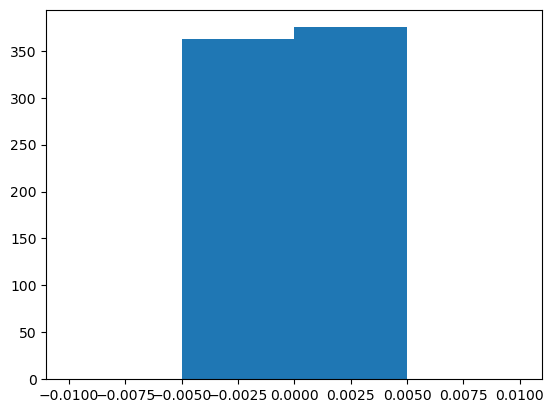

2.6862759415777456e-05
9.024677714272343e-06


In [58]:
plt.figure()
plt.hist(rewards, bins=np.arange(-.01, .0105, .005))
plt.show()
print(np.mean(rewards))
print(np.median(rewards))

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.

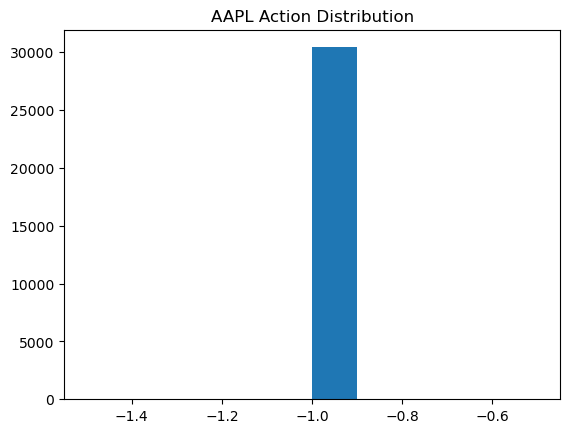

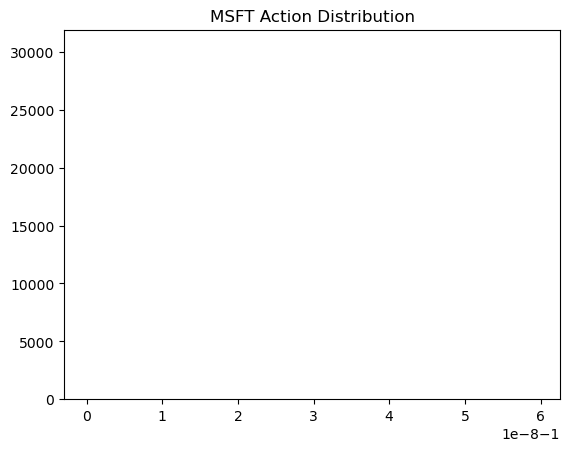

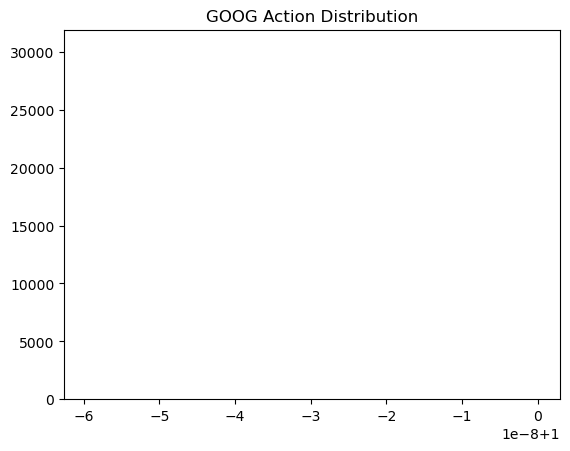

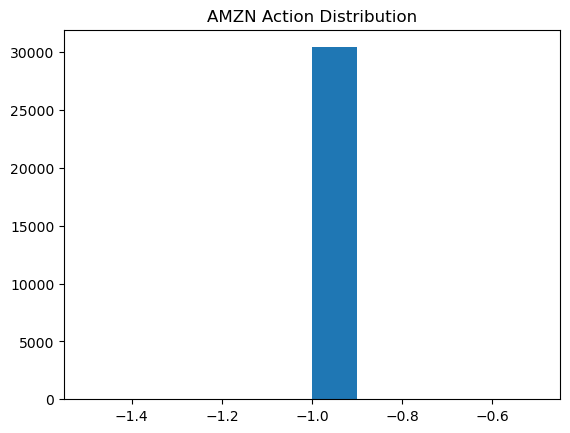

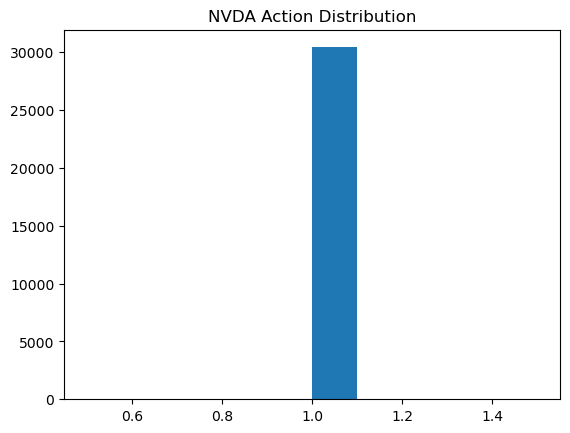

In [86]:
for ii in range(len(stocks_to_use)):
    plt.figure()
    plt.title(f"{stocks_to_use[ii]} Action Distribution")
    
    toplt = [xx[ii] for xx in actions]
    print(toplt)
    plt.hist(toplt)

In [50]:
actions

[array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1.,  1.,  1.,  1.], dtype=float32),
